# Question 1
## Image Transformations

In [93]:
import cv2
import numpy as np
from src.functions import imread, imshow

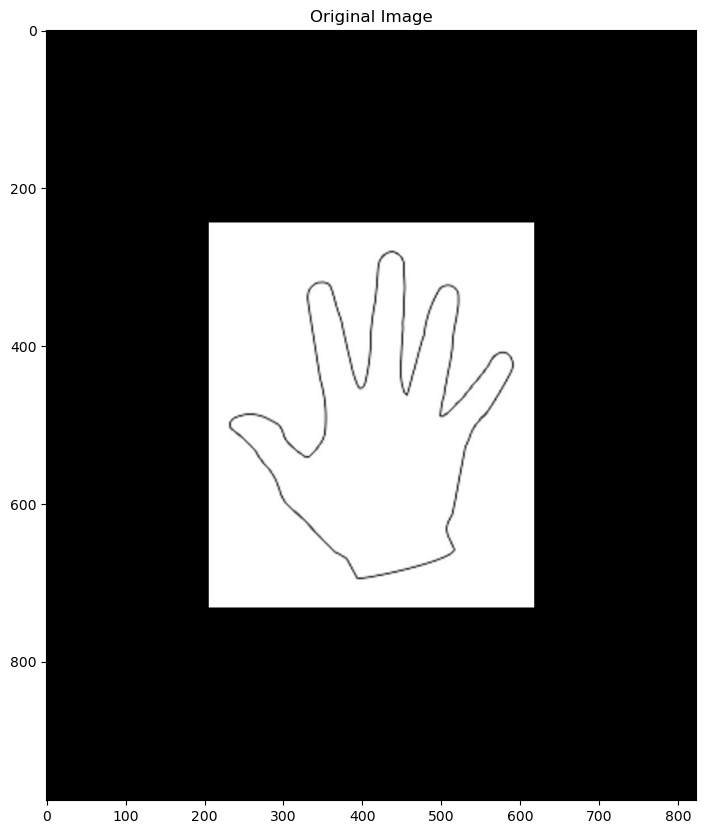

In [94]:
original_image = imread('images/Original_image.jpg')
imshow(original_image , "Original Image")

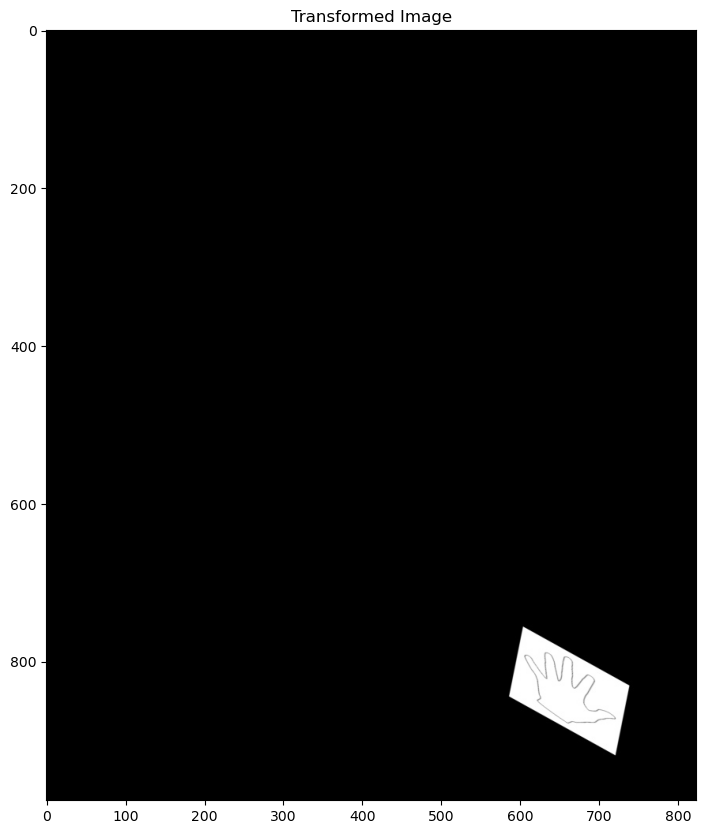

In [95]:
transformed_image = imread('images/transformed_image.jpg')
imshow(transformed_image , "Transformed image")

## Moments
Here we will calculate the moments of the original and transformed image.
From the moments we can calculate the centroid of the images. The centroid is the center of mass of the image
which helps us reverse engineer the transformation and have a reference point to compare the original and transformed image.

In [97]:
# Convert the images to grayscale from RGB
original_image_gray = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
transformed_image_gray = cv2.cvtColor(transformed_image, cv2.COLOR_RGB2GRAY)

In [98]:
# Converting the images to binary
_, original_image_binary = cv2.threshold(original_image_gray, 127, 255, cv2.THRESH_BINARY)
_, transformed_image_binary = cv2.threshold(transformed_image_gray, 127, 255, cv2.THRESH_BINARY)


In [99]:
# Calculate moments of the binary original image
original_moments = cv2.moments(original_image_binary)


# Use the moments to calculate the centroid of original image
original_centroid_x = original_moments['m10'] / original_moments['m00']
original_centroid_y = original_moments['m01'] / original_moments['m00']

original_centroid_x, original_centroid_y

(411.2529058602357, 487.82029149568416)

In [100]:
# Calculate moments of the binary transformed image
transformed_moments = cv2.moments(transformed_image_binary)

# Use the moments to calculate the centroid of transformed image
transformed_centroid_x = transformed_moments['m10'] / transformed_moments['m00']
transformed_centroid_y = transformed_moments['m01'] / transformed_moments['m00']

transformed_centroid_x, transformed_centroid_y

(661.8243284032599, 837.2891638997887)

In [101]:
transformed_image.shape

(976, 824, 3)

In [102]:
heigth, width = original_image.shape[0], original_image.shape[1] # storing height and width of image in defined values

## First Transformation
### Translation

In [103]:
delta_x = original_centroid_x - transformed_centroid_x
delta_y = original_centroid_y - transformed_centroid_y

translation_matrix = np.float32([[1, 0, delta_x], [0, 1, delta_y]])  # going back delta_x pixels in x-axis and delta_y pixels in y-axis
img_transform_1 = cv2.warpAffine(transformed_image, translation_matrix, (width, heigth))

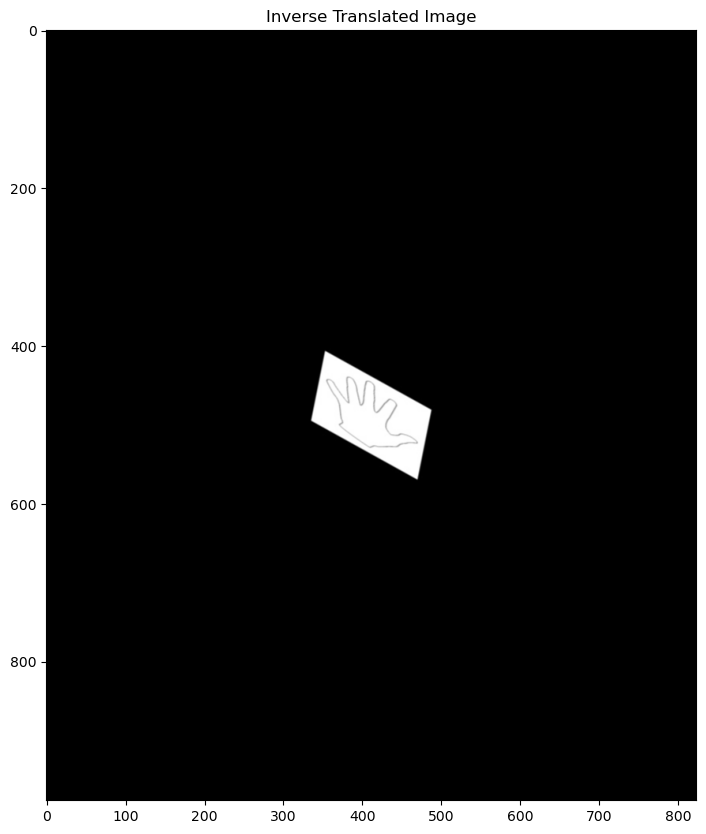

In [104]:
imshow(img_transform_1, "inverse translated image")

## Second Transformation
### Rotation

In [105]:
# Finding the rotation angle by trial and error
img_transform_2 = cv2.warpAffine(img_transform_1, cv2.getRotationMatrix2D((original_centroid_x, original_centroid_y), 29, 1), (width, heigth))

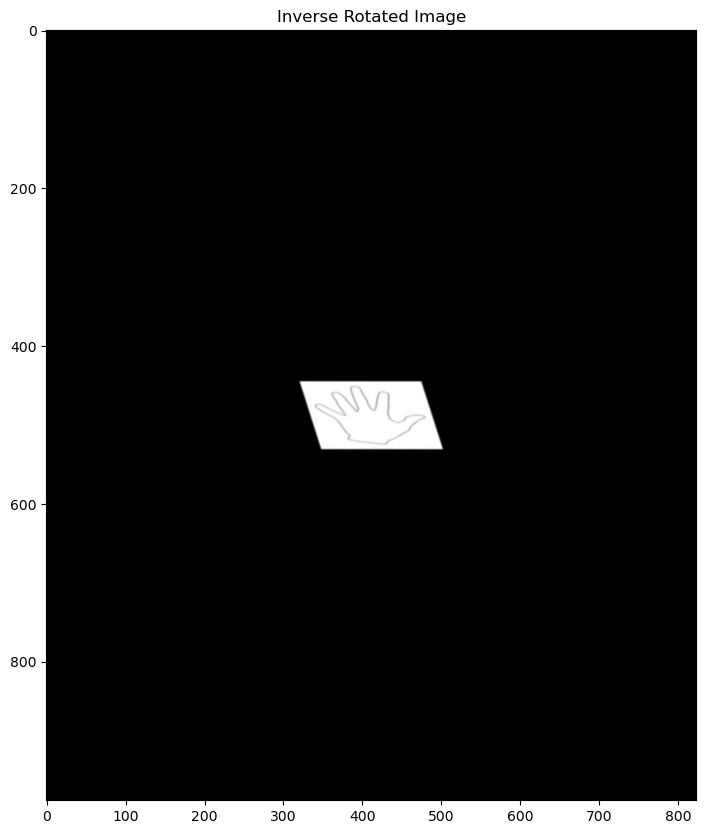

In [106]:
imshow(img_transform_2, "inverse rotated image")

## Third Transformation
### Shear

First we find the bounding rect of the image we calculated in the previous section.
This bounding rect serves as the reference point for the transformation. If we find a matrix that maps sheared contour to bounding rect then we can reverse engineer the transformation.

In [107]:
img_transform_2_gray = cv2.cvtColor(img_transform_2, cv2.COLOR_RGB2GRAY)

In [108]:
_, img_transform_2_binary = cv2.threshold(img_transform_2_gray, 127, 255, cv2.THRESH_BINARY)

In [109]:
contours, _ = cv2.findContours(img_transform_2_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = max(contours, key=cv2.contourArea)

In [110]:
x, y, w, h = cv2.boundingRect(contour)

In [111]:
print(x, y, w, h) # coordinates of the desired image

321 445 181 86


In [112]:
# Calculating coordinates of sheared image using approximate contour
accuracy = 0.02 * cv2.arcLength(contour, True)
sheared_img_contour = cv2.approxPolyDP(contour, accuracy, True)
print(sheared_img_contour)

[[[321 446]]

 [[348 530]]

 [[501 530]]

 [[473 445]]]


In [113]:
# Coordinates of the corners of the sheared image
sheared_corners = np.float32([
    [321, 446],  # Top-left
    [473, 445],  # Top-right
    [348, 530],  # Bottom-left
    [501, 530]   # Bottom-right
])

# Coordinates of the corners of the original image
original_corners = np.float32([
    [321, 445],   # Top-left
    [502, 445],   # Top-right
    [321, 531],   # Bottom-left
    [502, 531]    # Bottom-right
])

# Calculating Transformation matrix
deshear_matrix = cv2.getPerspectiveTransform(sheared_corners, original_corners)

In [126]:
# Finding shear matrix which in inverse of deshear matrix
shear_matrix = np.linalg.inv(deshear_matrix)
shear_matrix

array([[ 7.78842724e-01,  2.85163473e-01, -6.78855325e+01],
       [-3.31635449e-02,  9.14290393e-01,  3.31421751e+01],
       [-6.25727263e-05, -4.90623816e-05,  1.00460000e+00]])

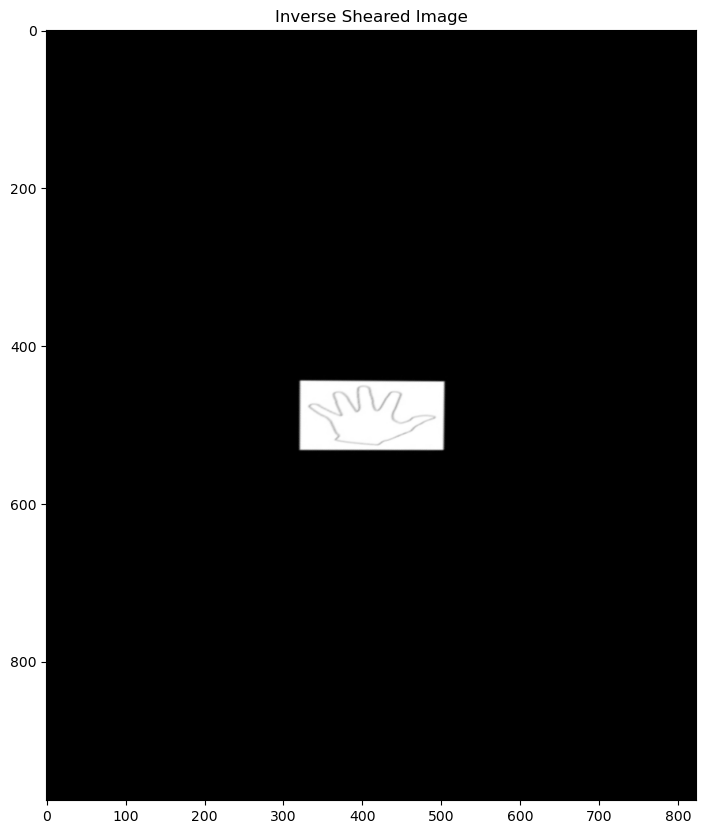

In [125]:
img_transform_3 = cv2.warpPerspective(img_transform_2, deshear_matrix, (width, heigth))
imshow(img_transform_3, "inverse sheared Image")

## Fourth Transformation
### Reflection

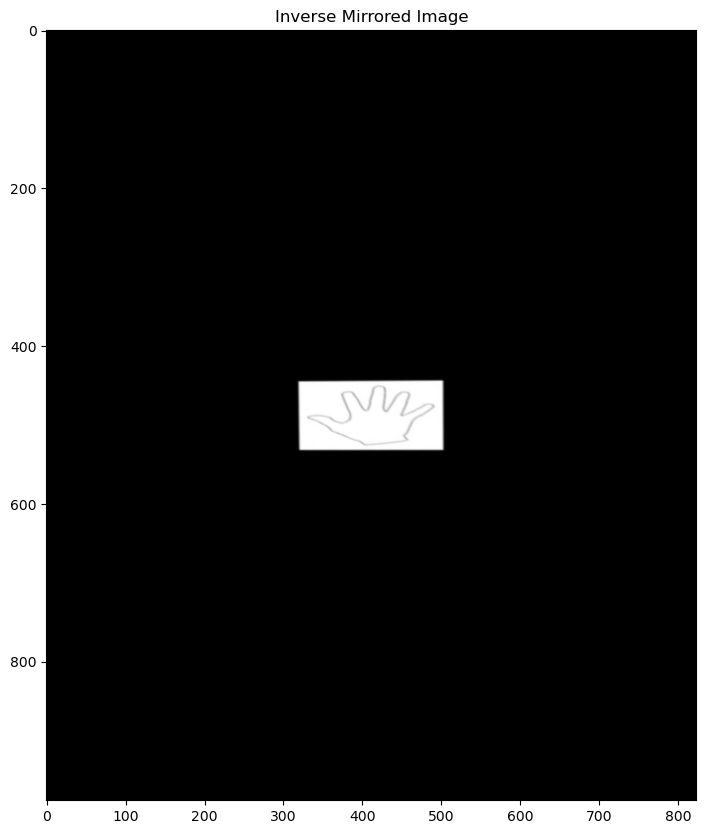

In [115]:
img_transform_4 = cv2.flip(img_transform_3, 1)
imshow(img_transform_4, "inverse mirrored image")

## Fifth Transformation
### Scale

First we calculate the contours of the original and transformed image. Then we extract the contour of white square in each image.
We can find the scaling factor by dividing the contour area of original image by the contour area of the transformed image.

In [116]:
# Turning the original image into grayscale and then binarize it
original_image_gray = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
_, original_image_binary = cv2.threshold(original_image_gray, 127, 255, cv2.THRESH_BINARY) 

In [117]:
# Finding the contour of white square
contours, _ = cv2.findContours(original_image_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_original = max(contours, key=cv2.contourArea)

In [118]:
x1, y1, w1, h1 = cv2.boundingRect(contour_original) # Coordinates of the white square in original image
print(x1, y1, w1, h1)

206 244 412 488


In [119]:
# Turning the image of previous section into gray scale and then binarize it
img_transform_4_gray = cv2.cvtColor(img_transform_4, cv2.COLOR_RGB2GRAY)
_, img_transform_4_binary = cv2.threshold(img_transform_4_gray, 127, 255, cv2.THRESH_BINARY)

In [120]:
# Finding the contour of white square
contours, _ = cv2.findContours(img_transform_4_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_transformed = max(contours, key=cv2.contourArea)

In [121]:
x2, y2, w2, h2 = cv2.boundingRect(contour_transformed) # Coordinates of the white square in transformed image from previous section
print(x2, y2, w2, h2)

320 444 183 88


In [122]:
# Coordinates of the corners of the sheared image
original_image_corners = np.float32([
    [206, 244],  # Top-left
    [618, 244],  # Top-right
    [206, 732],  # Bottom-left
    [618, 732]   # Bottom-right
])

# Coordinates of the corners of the original image
transformed_image_corners = np.float32([
    [320, 444],   # Top-left
    [503, 444],   # Top-right
    [320, 532],   # Bottom-left
    [503, 532]    # Bottom-right
])

In [123]:
descaled_matrix = cv2.getPerspectiveTransform(transformed_image_corners, original_image_corners)

In [128]:
# Finding the scale matrix which is the inverse of descaled matrix
scale_matrix = np.linalg.inv(descaled_matrix)
scale_matrix

array([[4.44174757e-01, 2.69917219e-16, 2.28500000e+02],
       [2.59787302e-16, 1.80327869e-01, 4.00000000e+02],
       [5.65448620e-19, 8.48172930e-19, 1.00000000e+00]])

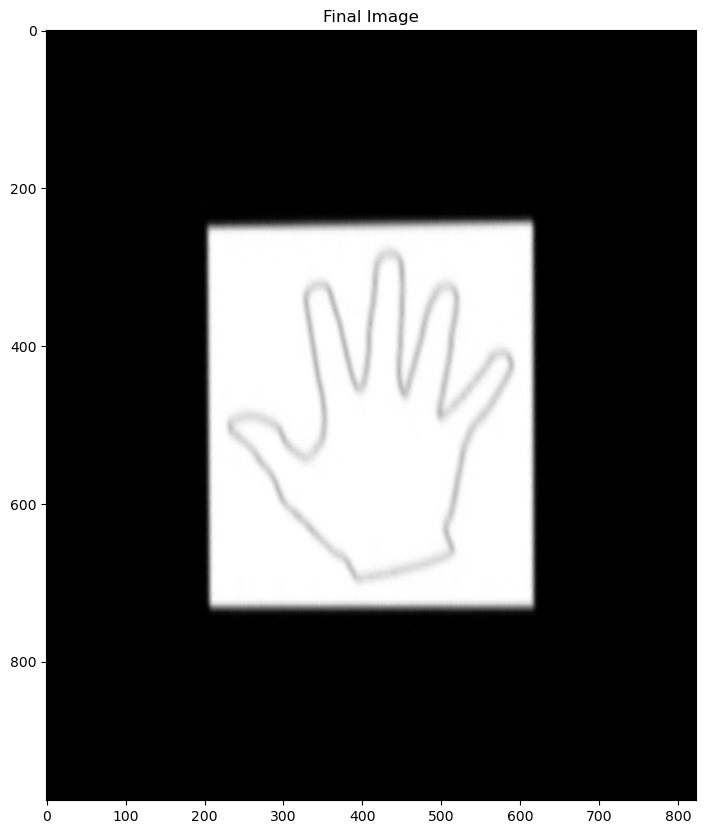

In [124]:
img_transform_5 = cv2.warpPerspective(img_transform_4, descaled_matrix, (width, heigth))
imshow(img_transform_5, "Final Image")